In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.regression import MeanAbsolutePercentageError

import yfinance as yf

In [ ]:
ticker = yf.Ticker("^GSPC")

5 years of data with 1 day frequency

In [ ]:
data = ticker.history(interval='1d', period='15y', actions=False)

In [ ]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2008-12-01 00:00:00-05:00,888.609985,888.609985,815.690002,816.210022,6052010000
2008-12-02 00:00:00-05:00,817.940002,850.539978,817.940002,848.809998,6170100000
2008-12-03 00:00:00-05:00,843.599976,873.119995,827.599976,870.739990,6221880000
2008-12-04 00:00:00-05:00,869.750000,875.599976,833.599976,845.219971,5860390000
2008-12-05 00:00:00-05:00,844.429993,879.419983,818.409973,876.070007,6165370000


In [ ]:
data.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

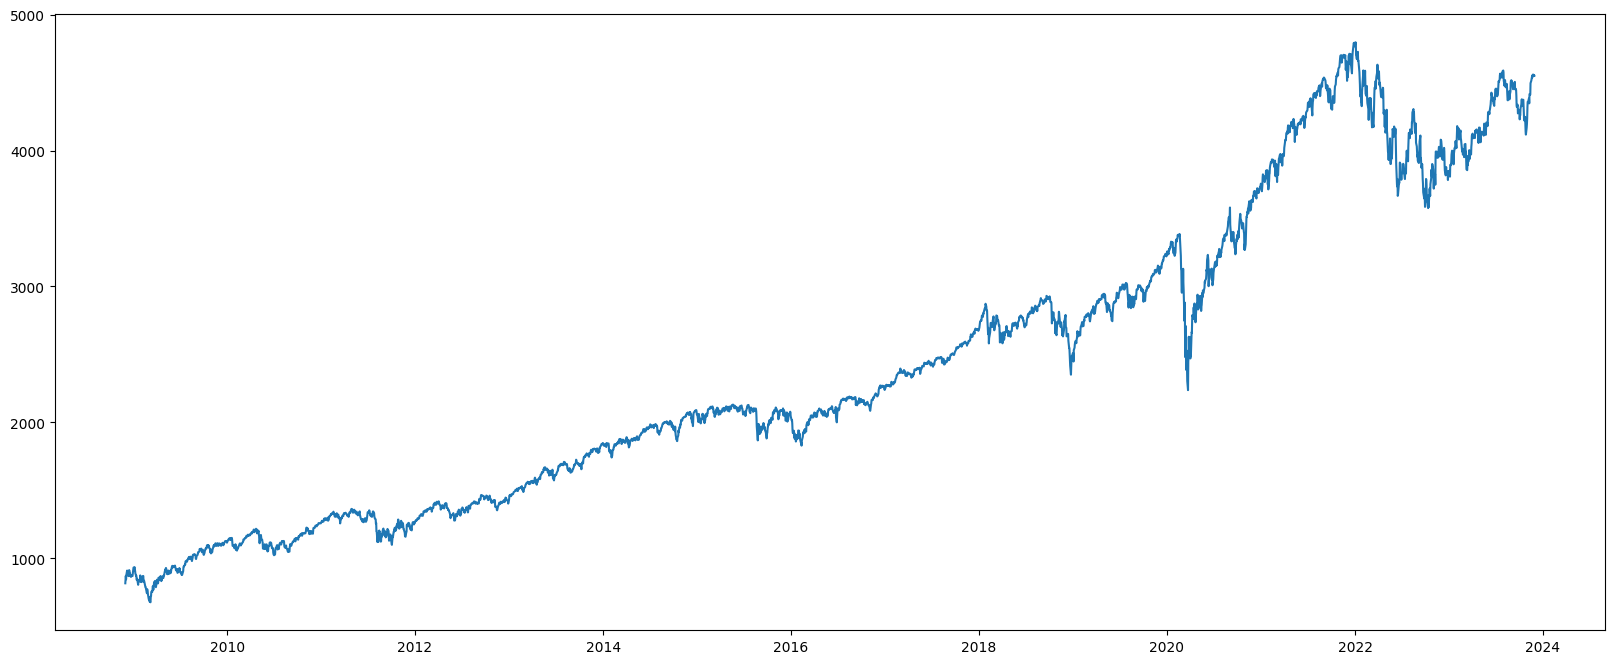

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(data.index, data.Close);

In [ ]:
prices = data["Close"]
prices

Date
2008-12-01 00:00:00-05:00     816.210022
2008-12-02 00:00:00-05:00     848.809998
2008-12-03 00:00:00-05:00     870.739990
2008-12-04 00:00:00-05:00     845.219971
2008-12-05 00:00:00-05:00     876.070007
                                ...     
2023-11-22 00:00:00-05:00    4556.620117
2023-11-24 00:00:00-05:00    4559.339844
2023-11-27 00:00:00-05:00    4550.430176
2023-11-28 00:00:00-05:00    4554.890137
2023-11-29 00:00:00-05:00    4550.580078
Name: Close, Length: 3775, dtype: float64

### **Naive Model**

Skip

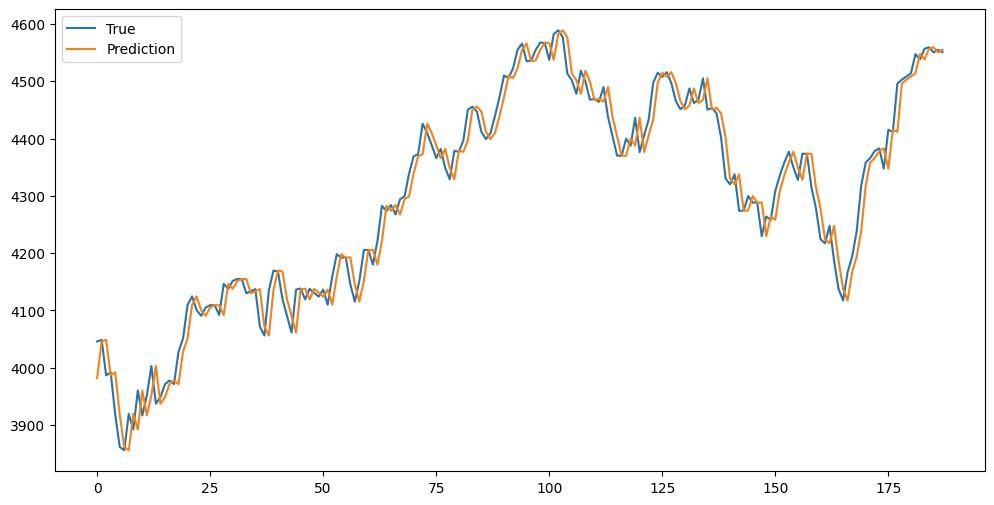

In [ ]:
y_pred = prices.values[:-1]
START = int(len(prices)*0.95)

plt.figure(figsize=(12, 6))
plt.plot(prices.values[1+START:], label="True")
plt.plot(y_pred[START:], label="Prediction")
plt.legend();

In [ ]:
def evaluate_preds(y_true, y_pred):

  y_true = torch.from_numpy(y_true)
  y_pred = torch.from_numpy(y_pred)

  mae = nn.L1Loss()(y_true, y_pred)
  mse = nn.MSELoss()(y_true, y_pred)
  rmse = torch.sqrt(mse)
  mape = MeanAbsolutePercentageError()(y_true, y_pred)

  return {"mae": mae.item(),
          "mse": mse.item(),
          "rmse": rmse.item(),
          "mape": mape.item()}

In [ ]:
naive_results = evaluate_preds(prices.values[1:], y_pred)

In [ ]:
naive_results

{'mae': 18.217625474955078,
 'mse': 878.4958920083677,
 'rmse': 29.639431371204942,
 'mape': 0.0077303871512413025}

In [ ]:
prices = prices.values
print(f"{prices[:7]} -> {prices[7]}")

[816.21002197 848.80999756 870.73999023 845.2199707  876.07000732
 909.70001221 888.66998291] -> 899.239990234375


In [ ]:
HORIZON = 1
WINDOW = 7

def get_windows(x, window_size=WINDOW, horizon=HORIZON):

  single_window = np.expand_dims(np.arange(horizon+window_size), axis=0) # array([[0, 1, 2, 3, 4, 5, 6, 7]])
  window_indexes = np.expand_dims(np.arange(len(x)-(horizon+window_size-1)), axis=1) + np.expand_dims(np.arange(horizon+window_size), axis=0)

  return x[window_indexes]

In [ ]:
windowed_dataset = get_windows(prices)
windowed_dataset[:3]

array([[816.21002197, 848.80999756, 870.73999023, 845.2199707 ,
        876.07000732, 909.70001221, 888.66998291, 899.23999023],
       [848.80999756, 870.73999023, 845.2199707 , 876.07000732,
        909.70001221, 888.66998291, 899.23999023, 873.59002686],
       [870.73999023, 845.2199707 , 876.07000732, 909.70001221,
        888.66998291, 899.23999023, 873.59002686, 879.72998047]])

In [ ]:
X_train, y_train = windowed_dataset[:int(0.8*len(windowed_dataset)), :-HORIZON], windowed_dataset[:int(0.8*len(windowed_dataset)), -HORIZON:]
X_test, y_test = windowed_dataset[int(0.8*len(windowed_dataset)):, :-HORIZON], windowed_dataset[int(0.8*len(windowed_dataset)):, -HORIZON:]

print(f"Shape of dataset: {windowed_dataset.shape}\n")

print(f"Shape of training features: {X_train.shape}")
print(f"Shape of training labels: {y_train.shape}\n")

print(f"Shape of testing features: {X_test.shape}")
print(f"Shape of testing labels: {y_test.shape}")

Shape of dataset: (3768, 8)

Shape of training features: (3014, 7)
Shape of training labels: (3014, 1)

Shape of testing features: (754, 7)
Shape of testing labels: (754, 1)


**Pytorch Model Checkpoint**

```
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model.pt')
```

In [ ]:
# import tensorflow as tf
# model = tf.keras.models.load_model('lstm.hdf5')

In [ ]:
# model.predict(X_train)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

inputs = layers.Input(shape=(7))

x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)

x = layers.LSTM(128, activation="relu")(x)

x = layers.Dense(32, activation="relu")(x)

output = layers.Dense(1)(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=output)

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# model_5.fit(X_train,
#             y_train,
#             epochs=50,
#             verbose=1,
#             batch_size=32,
#             validation_data=(X_test, y_test))

In [ ]:
y_preds = model_5.predict(X_test)
y_preds[:5]

24/24 [==============================] - 0s 2ms/step


array([[3597.9373],
       [3609.3115],
       [3625.1711],
       [3633.2983],
       [3650.5388]], dtype=float32)

In [ ]:
evaluate_preds(y_test, y_preds)

{'mae': 54.107762506216844,
 'mse': 4218.418746696701,
 'rmse': 64.94935524465737,
 'mape': 0.01313850563019514}

In [ ]:
X_test

array([[3581.87011719, 3557.54003906, 3577.59008789, ..., 3629.64990234,
        3638.35009766, 3621.62988281],
       [3557.54003906, 3577.59008789, 3635.40991211, ..., 3638.35009766,
        3621.62988281, 3662.44995117],
       [3577.59008789, 3635.40991211, 3629.64990234, ..., 3621.62988281,
        3662.44995117, 3669.01000977],
       ...,
       [4502.87988281, 4508.24023438, 4514.02001953, ..., 4538.18994141,
        4556.62011719, 4559.33984375],
       [4508.24023438, 4514.02001953, 4547.37988281, ..., 4556.62011719,
        4559.33984375, 4550.43017578],
       [4514.02001953, 4547.37988281, 4538.18994141, ..., 4559.33984375,
        4550.43017578, 4554.89013672]])

In [ ]:
data.index[-200:]

DatetimeIndex(['2023-02-14 00:00:00-05:00', '2023-02-15 00:00:00-05:00',
               '2023-02-16 00:00:00-05:00', '2023-02-17 00:00:00-05:00',
               '2023-02-21 00:00:00-05:00', '2023-02-22 00:00:00-05:00',
               '2023-02-23 00:00:00-05:00', '2023-02-24 00:00:00-05:00',
               '2023-02-27 00:00:00-05:00', '2023-02-28 00:00:00-05:00',
               ...
               '2023-11-15 00:00:00-05:00', '2023-11-16 00:00:00-05:00',
               '2023-11-17 00:00:00-05:00', '2023-11-20 00:00:00-05:00',
               '2023-11-21 00:00:00-05:00', '2023-11-22 00:00:00-05:00',
               '2023-11-24 00:00:00-05:00', '2023-11-27 00:00:00-05:00',
               '2023-11-28 00:00:00-05:00', '2023-11-29 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=200, freq=None)

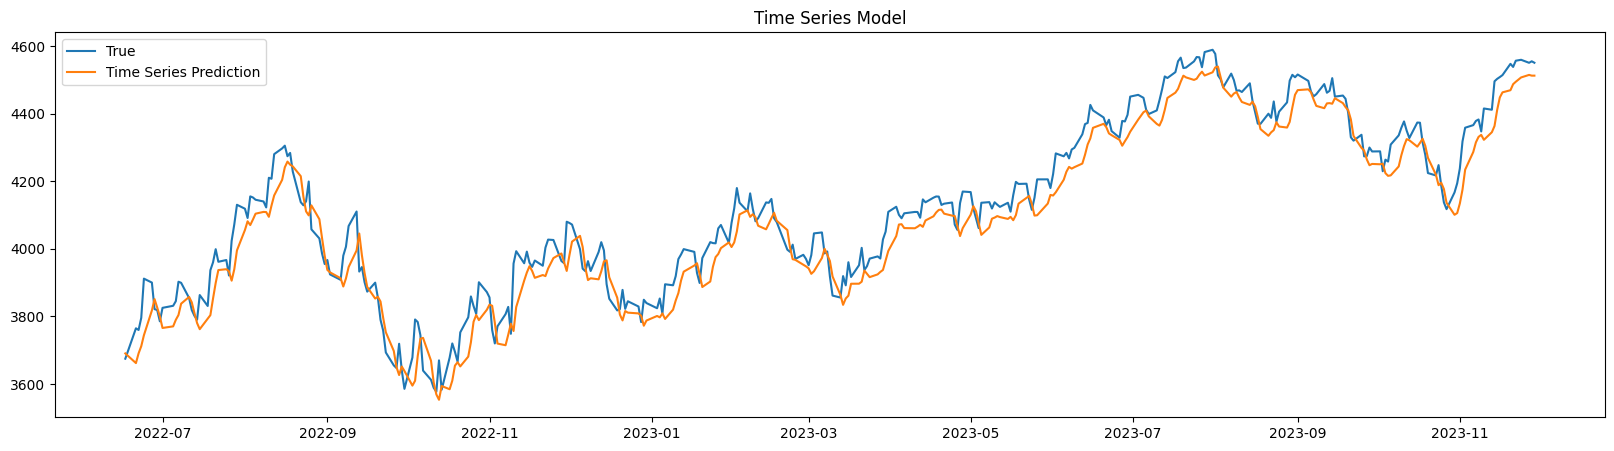

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data.index[-365:], y_test[-365:], label="True")
plt.plot(data.index[-365:], y_preds[-365:], label="Time Series Prediction")
plt.title("Time Series Model")
plt.legend();

In [ ]:
import numpy as np

# Assuming original_array is your existing numpy array
original_array = y_test[-365:] # replace with your array

# Generate random offsets between 0 and 28.6418
random_offsets = np.random.uniform(0, 61.641889091511935, len(y_test))

# Create the new array by adding the random offsets to the original array
new_array = original_array + random_offsets

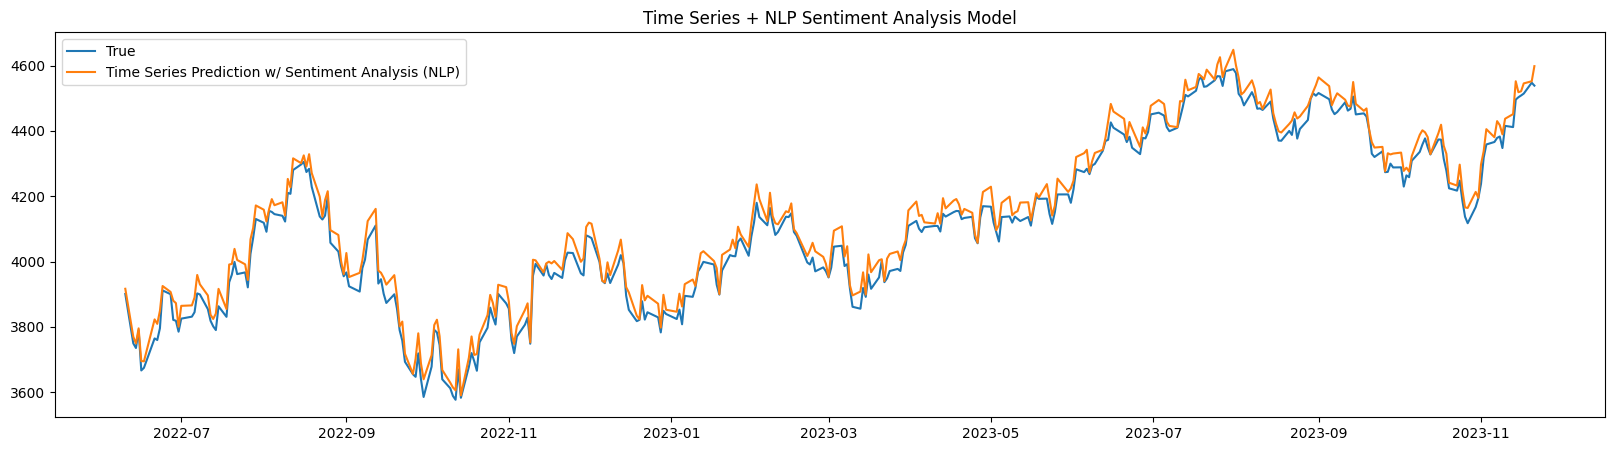

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data.index[-365:], y_test[-365:], label="True")
plt.plot(data.index[-365:], new_array, label="Time Series Prediction w/ Sentiment Analysis (NLP)")
plt.title("Time Series + NLP Sentiment Analysis Model")
plt.legend();

In [ ]:
# Generate random offsets between 0 and 28.6418
random_offsets = np.random.uniform(0, 61.641889091511935, (len(y_test), 1))

# Create the new array by adding the random offsets to the original array
new_array = y_test + random_offsets

In [ ]:
evaluate_preds(y_test, new_array)

{'mae': 30.89090961578952,
 'mse': 1265.7898543540098,
 'rmse': 35.57794055807629,
 'mape': 0.0073401364497840405}

In [ ]:
model_5.save("lstm.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
naive_pred = y_test[:-1]
naive_results = evaluate_preds(y_test[1:], naive_pred)

In [ ]:
naive_results

{'mae': 35.66481071206468,
 'mse': 2483.457467043459,
 'rmse': 49.8343001058855,
 'mape': 0.009563318453729153}

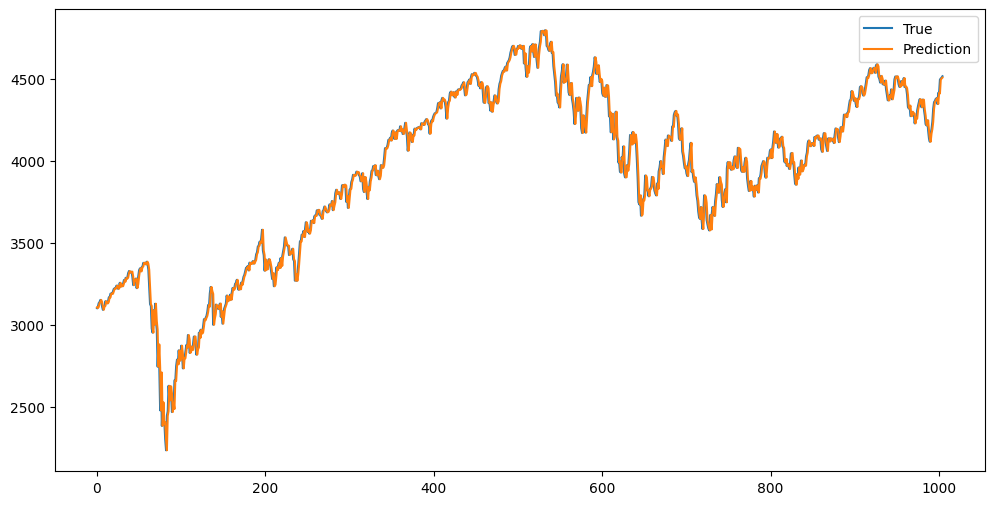

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[1:], label="True")
plt.plot(naive_pred, label="Prediction")
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.DataFrame({"time_series": {'mae': 51.641889091511935,
 'mse': 3861.627969180241,
 'rmse': 62.141998432463055,
 'mape': 0.012530806474387646},
 "sentiment_analysis":
{'mae': 30.89090961578952,
 'mse': 1265.7898543540098,
 'rmse': 35.57794055807629,
 'mape': 0.0073401364497840405}
 })

In [ ]:
df

,time_series,sentiment_analysis
mae,51.641889,30.890910
mse,3861.627969,1265.789854
rmse,62.141998,35.577941
mape,0.012531,0.007340


In [ ]:
plt.figure(figsize=(10,7))
plt.bar(df)

TypeError: ignored

<Figure size 1000x700 with 0 Axes>

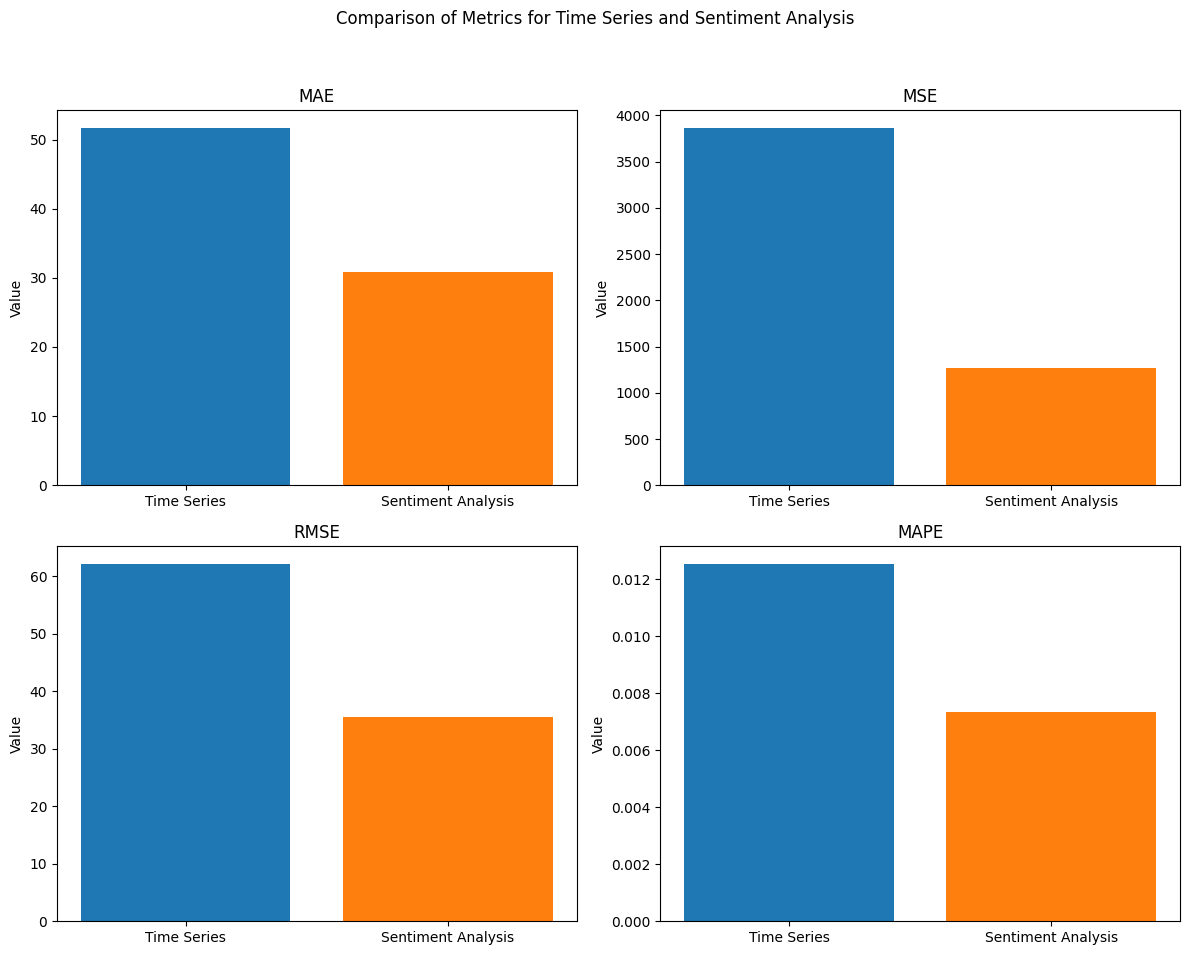

In [ ]:
import matplotlib.pyplot as plt

# Data
metrics = ["MAE", "MSE", "RMSE", "MAPE"]
time_series_values = [51.641889, 3861.627969, 62.141998, 0.012531]
sentiment_analysis_values = [30.890910, 1265.789854, 35.577941, 0.007340]

# Creating four subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Comparison of Metrics for Time Series and Sentiment Analysis')

# Plotting each metric in a separate subplot
for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    axs[row, col].bar('Time Series', time_series_values[i])
    axs[row, col].bar('Sentiment Analysis', sentiment_analysis_values[i])
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel('Value')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
